In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from joblib import Parallel, delayed

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [2]:
import duckdb
import pandas as pd

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb://

In [3]:
dataset_path = 'C:/Users/pedro/Documents/DMEyF/dmeyf2025/data/'
dataset_file = 'processed/competencia_01.csv'

data = pd.read_csv(dataset_path + dataset_file)

In [4]:
%%sql
create or replace table competencia_01 as
select
    *
from read_csv_auto("{{dataset_path + dataset_file}}")

,Success


In [5]:
%%time
%%sql
create or replace table competencia_01 as
SELECT
    * EXCLUDE(clase_ternaria),
    (ctarjeta_debito_transacciones + ctarjeta_visa_transacciones + ctarjeta_master_transacciones) as ctarjeta_total_transacciones,
    (ctarjeta_visa_transacciones + ctarjeta_master_transacciones) as ctarjeta_credito_transacciones,
    if(cpayroll_trx > 0 , 1, 0) as cpayroll,
    (mcaja_ahorro + mcaja_ahorro_adicional + mcaja_ahorro_dolares) as mcaja_ahorro_total,
    (mtarjeta_visa_consumo + mtarjeta_master_consumo) as mtarjeta_credito_consumo,
    (mplazo_fijo_pesos + mplazo_fijo_dolares) as mplazo_fijo_total,
    (Visa_mlimitecompra + Master_mlimitecompra) as credito_mlimitecompra,
    (mcuenta_corriente_adicional+mcuenta_corriente+mcaja_ahorro+mcaja_ahorro_adicional+mcaja_ahorro_dolares+mcuentas_saldo+mplazo_fijo_dolares+mplazo_fijo_pesos+minversion1_pesos+minversion1_dolares+minversion2) as mbanco_total,
    (mprestamos_personales + mprestamos_prendarios + mprestamos_hipotecarios) as mprestamos_total,
    if(mrentabilidad_annual = 0, 0, mrentabilidad / mrentabilidad_annual) as porc_mrentabilidad_annual,
    clase_ternaria
FROM competencia_01

CPU times: total: 2.55 s
Wall time: 1.03 s


,Success


In [6]:
%%sql
COPY competencia_01 TO '{{dataset_path}}processed/competencia_01_fe.csv' (FORMAT CSV, HEADER);

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [7]:
#Modificar segun la estructura de sus carpetas, no se olviden crear las que faltan
base_path = 'C:/Users/pedro/Documents/DMEyF/dmeyf2025/'
dataset_path = base_path + 'data/processed/'
modelos_path = base_path + 'models/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe.csv'

ganancia_acierto = 780000
costo_estimulo = 20000
prob_threshold = 0.025

mes_train = [202101, 202102, 202103]
mes_test = 202104
mes_predict = 202106

# agregue sus semillas
semillas = [154277, 204007, 223207, 301013, 639083]

data = pd.read_csv(dataset_path + dataset_file)

In [8]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [9]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [10]:
train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [11]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

In [12]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

In [13]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

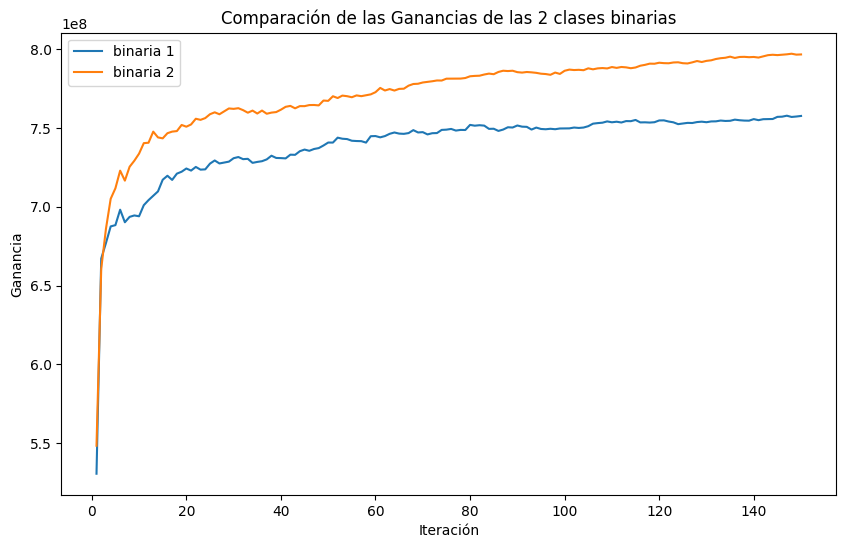

In [14]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

In [25]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0],
        callbacks=[
                lgb.early_stopping(stopping_rounds=int(50 + 5/learning_rate), verbose=False),
                lgb.log_evaluation(period=200),
                ]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm_pf.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-10-05 16:57:40,185] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [ ]:
# study.optimize(objective, n_trials=30) # subir subir

[I 2025-10-05 16:58:01,592] Trial 36 finished with value: 890860000.0 and parameters: {'num_leaves': 94, 'learning_rate': 0.1050958697896835, 'min_data_in_leaf': 489, 'feature_fraction': 0.5796518563970642, 'bagging_fraction': 0.9215418009528955}. Best is trial 20 with value: 890860000.0.
[I 2025-10-05 16:58:25,938] Trial 37 finished with value: 891300000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.1093672589396711, 'min_data_in_leaf': 491, 'feature_fraction': 0.4704768957766941, 'bagging_fraction': 0.9096605210156818}. Best is trial 37 with value: 891300000.0.
[I 2025-10-05 16:58:50,289] Trial 38 finished with value: 864320000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.06527230264341896, 'min_data_in_leaf': 574, 'feature_fraction': 0.4490908263191275, 'bagging_fraction': 0.8401279202355884}. Best is trial 37 with value: 891300000.0.
[I 2025-10-05 16:59:07,298] Trial 39 finished with value: 875320000.0 and parameters: {'num_leaves': 68, 'learning_rate': 0.10840

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
plot_param_importances(study)

In [29]:
plot_slice(study)

In [30]:
plot_contour(study)

In [31]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

In [32]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 100


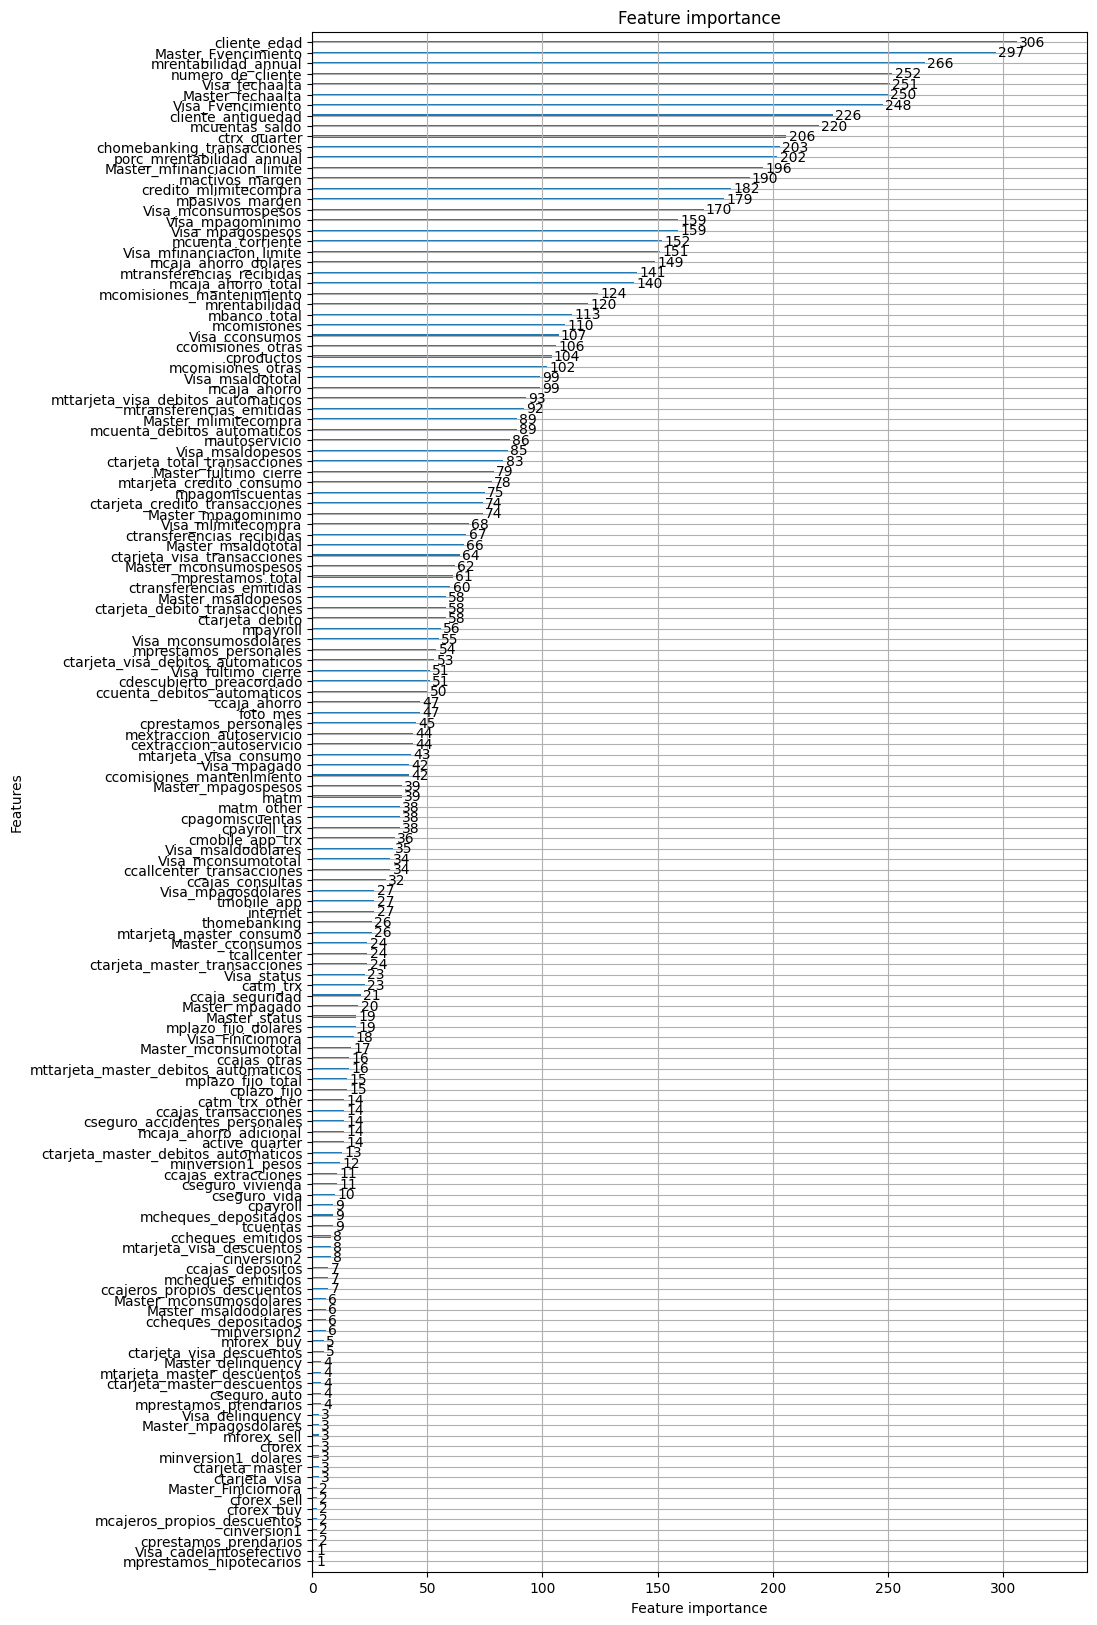

In [33]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()

In [34]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]

,feature,importance
5,cliente_edad,306
113,Master_Fvencimiento,297
8,mrentabilidad_annual,266
0,numero_de_cliente,252
149,Visa_fechaalta,251
...,...,...
76,cforex_buy,2
66,mcajeros_propios_descuentos,2
114,Master_Finiciomora,2
152,Visa_cadelantosefectivo,1


In [35]:
model.save_model(modelos_path + 'lgb_first.txt')

In [36]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

In [37]:
y_pred_lgm = model.predict(X_test)

In [38]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia LGBM:", ganancia_prob(y_pred_lgm, y_test_binaria1))

Ganancia LGBM: 354160000.0


In [39]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


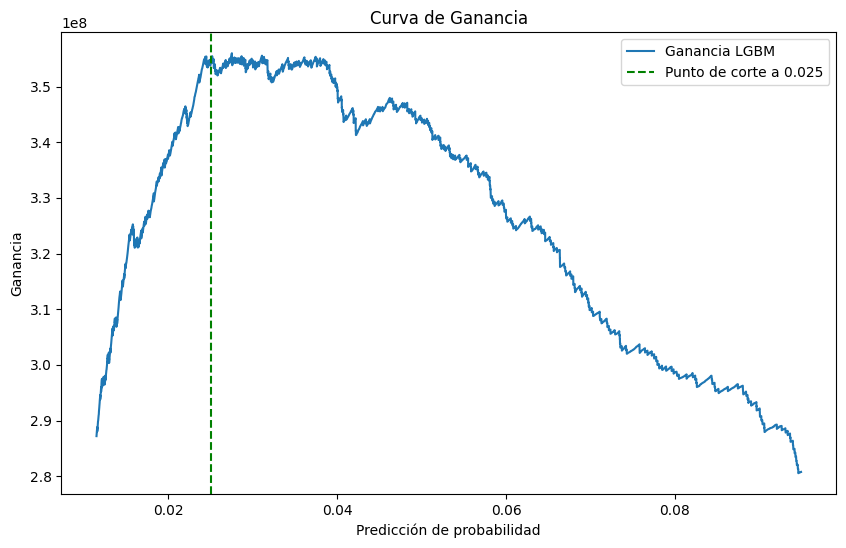

In [40]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

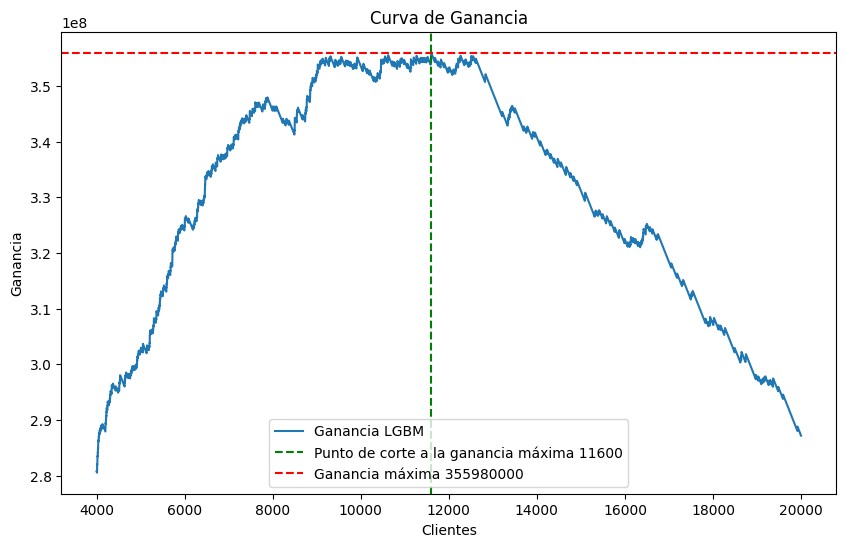

In [41]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

### Crear predicción para Kaggle

#### Entrenar el modelo con todos los datos

In [42]:
mes_total = mes_train
mes_total.append(mes_test)

total_data = data[data['foto_mes'].isin(mes_total)].copy()
y_total = total_data['clase_ternaria'].copy()

X_total = total_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1).copy()
y_total_binaria1 = total_data['clase_binaria1']
y_total_binaria2 = total_data['clase_binaria2']
y_total_class = total_data['clase_ternaria']
w_total = total_data['clase_peso']

X_predict = data[data['foto_mes'] == mes_predict].drop(columns=['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'])

In [43]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_total,
                          label=y_total_binaria2,
                          weight=w_total)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 100


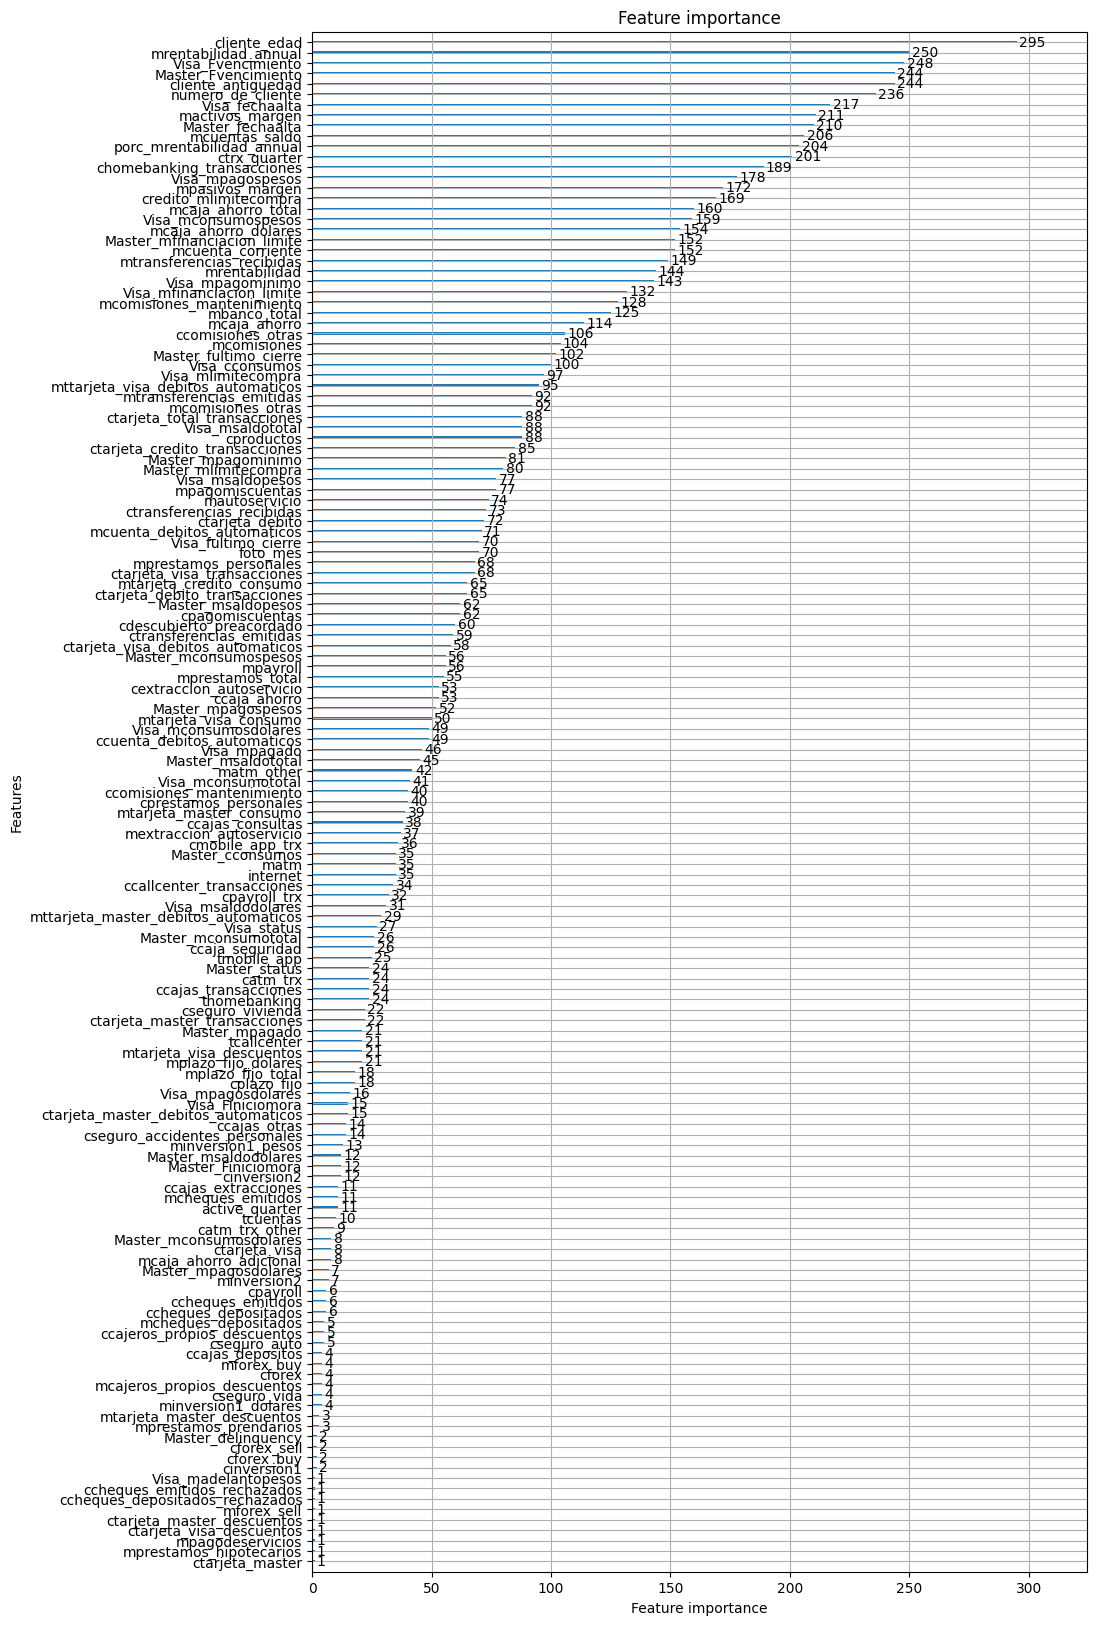

In [44]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()

In [45]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]

,feature,importance
5,cliente_edad,295
8,mrentabilidad_annual,250
135,Visa_Fvencimiento,248
6,cliente_antiguedad,244
113,Master_Fvencimiento,244
...,...,...
90,ccheques_depositados_rechazados,1
92,ccheques_emitidos_rechazados,1
69,ctarjeta_master_descuentos,1
79,mforex_sell,1


In [46]:
y_pred = model.predict(X_predict)

In [47]:
y_pred

array([1.05279738e-04, 3.72469978e-05, 9.66003554e-05, ...,
       6.31423318e-04, 3.80943346e-01, 9.16609697e-04], shape=(164313,))

In [48]:
y_pred_prob_baja = y_pred

In [57]:
prob_threshold = 0.03
y_pred = (y_pred_prob_baja >= prob_threshold).astype(int)

In [58]:
valores, cuentas = np.unique(y_pred, return_counts=True)

print(valores)  # [1 2 3 4]
print(cuentas)  # [1 2 3 4]

[0 1]
[153310  11003]


In [59]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], shape=(164313,))

#### Crear archivo con output para Kaggle

In [60]:
# Crear DataFrame con número de cliente y predicción
df_resultados = pd.DataFrame({
    "numero_de_cliente": X_predict["numero_de_cliente"].values,
    "Predicted": y_pred
})

# Exportar a CSV
df_resultados.to_csv(base_path+"predicted/predicciones_lgbm_3.csv", index=False)